### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2022 Semester 2

## Project

## Import Libraries

In [2]:
import os
import math
import numpy as np
import cv2
from matplotlib import pyplot as plt
from tqdm import tqdm
import time
import threading
global THREAD_NUM 

## Load sample images

In [13]:
# read the photos and disparity maps in the folder and save them in
# a dictionary indexed by the file name

cwd = os.getcwd()
data_set = cwd +"/Dataset"

file_names = os.listdir(data_set)

imgs = {}
ground_truth = {}
for i in range(len(file_names)):
    if file_names[i].endswith('.jpg'):
        fname = file_names[i][:43]
        ftype = file_names[i][-4:]
        imgs[fname] = [cv2.imread(data_set + '/' + fname  + '-left.jpg',cv2.IMREAD_GRAYSCALE), cv2.imread(data_set + '/' + fname  + '-right.jpg',cv2.IMREAD_GRAYSCALE)]
        ground_truth[fname] = cv2.imread(data_set + '/' + fname  + '-disparity.png', -1)  # 16bit png

## Show sample image

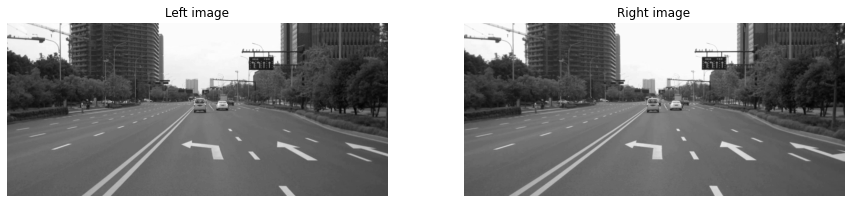

In [4]:
# Show images
img_name = "2018-07-09-16-11-56_2018-07-09-16-11-56-702"
plt.subplots(figsize=(15, 15)) 

plt.subplot(1,2,1)
plt.imshow(imgs[img_name][0], cmap='gray')  
plt.title("Left image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(imgs[img_name][1], cmap='gray')  
plt.title("Right image")
plt.axis('off')

plt.show() 

# Question 1
To calculate a disparity map for the left image using classical (non deep learning) methods

## Sum of Squared Differences (SSD)

In [22]:
global SEARCH_BLOCK_SIZE
SEARCH_BLOCK_SIZE = 32
THREAD_NUM = 16
# thread function
def ssd_(st,end,imgL,imgR,window_size,disparity):
    width, height = imgL.shape[:2]

    for i in range(st,end):
      for j in range(window_size//2, height-window_size//2):
          min_ssd = float('inf')
          for k in range(SEARCH_BLOCK_SIZE):
            if j-k < window_size//2:
              break
            ssd = np.sum((imgL[i-window_size//2:i+window_size//2+1, j-window_size//2:j+window_size//2+1] - imgR[i-window_size//2:i+window_size//2+1, j-window_size//2-k:j+window_size//2+1-k])**2)
  
            if ssd < min_ssd:
              min_ssd = ssd
              disparity[i,j] = k 


def ssd(imgL,imgR,window_size):
  width, height = imgL.shape[:2] 
  d = np.zeros((width, height), np.uint16)
  st = window_size//2
  end = width-window_size//2
  chunk = math.ceil((end - st) / THREAD_NUM)
  thread_list = []
  for treadno in range(THREAD_NUM):
    i_end = min((st + chunk * (treadno+1),end))
    t = threading.Thread(target=ssd_,args=((st + chunk * treadno),i_end,imgL,imgR,window_size,d))
    t.start()
    thread_list.append(t)
  for i in range(len(thread_list)):
    thread_list[i].join()
  return d

## Disparity map calculation

In [22]:
disparity = {}
for fname in imgs.keys():
  start_time = time.time()

  width, height = imgs[fname][0].shape[:2]
  disparity[fname] = ssd(imgs[fname][0],imgs[fname][1],15) 

  end_time = time.time()
  run_time = end_time - start_time
print(run_time)

# Normalized Cross Correlation (NCC)

In [24]:
def ncc(imgL,imgR,window_size):
    width, height = imgL.shape[:2]
    disparity = np.zeros((width, height), np.uint8)

    for i in tqdm(range(window_size//2, width-window_size//2)):
        for j in range(window_size//2, height-window_size//2):
            max_ncc = -1
            for k in range(SEARCH_BLOCK_SIZE):
                if j-k < window_size//2:
                    break
                ncc = np.sum((imgL[i-window_size//2:i+window_size//2+1, j-window_size//2:j+window_size//2+1] - np.mean(imgL[i-window_size//2:i+window_size//2+1, j-window_size//2:j+window_size//2+1])) * (imgR[i-window_size//2:i+window_size//2+1, j-window_size//2-k:j+window_size//2+1-k] - np.mean(imgR[i-window_size//2:i+window_size//2+1, j-window_size//2-k:j+window_size//2+1-k]))) / (np.sqrt(np.sum((imgL[i-window_size//2:i+window_size//2+1, j-window_size//2:j+window_size//2+1] - np.mean(imgL[i-window_size//2:i+window_size//2+1, j-window_size//2:j+window_size//2+1]))**2)) * np.sqrt(np.sum((imgR[i-window_size//2:i+window_size//2+1, j-window_size//2-k:j+window_size//2+1-k] - np.mean(imgR[i-window_size//2:i+window_size//2+1, j-window_size//2-k:j+window_size//2+1-k]))**2)))
                if ncc > max_ncc:
                    max_ncc = ncc
                    disparity[i,j] = k
    return disparity

# Question 2

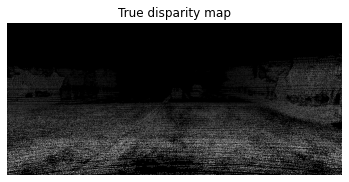

In [6]:
# Show images
plt.imshow(ground_truth[img_name], cmap='gray')  
plt.title("True disparity map")
plt.axis('off')

plt.show() 

## Errors

In [15]:
def errors(img_truth,estimated_disparity):
  avliable_pixels = np.where(img_truth != 0)
  errors = np.abs(img_truth[avliable_pixels]-estimated_disparity[avliable_pixels])
  # root mean square error
  rms = np.sqrt(np.mean(errors **2))
  # percentage of errors by pixels
  errors4 = np.where(errors < 4)[0].shape[0]/avliable_pixels[0].shape[0] 
  errors2 = np.where(errors < 2)[0].shape[0]/avliable_pixels[0].shape[0] 
  errors1 = np.where(errors < 1)[0].shape[0]/avliable_pixels[0].shape[0] 
  errors0_5 = np.where(errors< 0.5)[0].shape[0]/avliable_pixels[0].shape[0] 
  errors0_25 = np.where(errors < 0.25)[0].shape[0]/avliable_pixels[0].shape[0] 

  return rms, (errors4,errors2,errors2,errors0_5,errors0_25)


In [137]:
print(img_name)
errors(ground_truth[img_name]/256,disparity[img_name]/256)

2018-07-09-16-11-56_2018-07-09-16-11-56-702


(20.445513695225685,
 (0.5446800304030676,
  0.4638736684477419,
  0.4638736684477419,
  0.2217722265709197,
  0.12458451031775743))

In [136]:
x = cv2.GaussianBlur(disparity[img_name], (3,3), 1.5);
errors(ground_truth[img_name]/256,x/256)

(20.297210412433337,
 (0.5414355239424157,
  0.4641913124368966,
  0.4641913124368966,
  0.23097255782822268,
  0.13195838863742074))

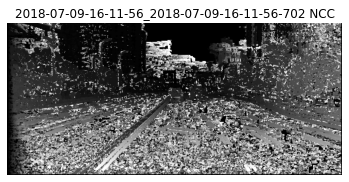

(18.468195777946868,
 (0.4875721789243213,
  0.40893260275215826,
  0.40893260275215826,
  0.18863515184517124,
  0.10322295204710207))

In [5]:

img_name = "2018-07-09-16-11-56_2018-07-09-16-11-56-702"
d_ncc = ssd(imgs[img_name][0],imgs[img_name][1],7)
plt.imshow(d_ncc, cmap='gray')
plt.title(img_name + " NCC")
plt.axis('off')

plt.show()

errors(ground_truth[img_name]/256,d_ncc)

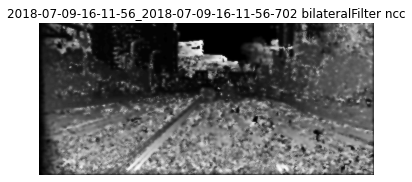

When using bilateralFilter can significantly reduces errors.
rms error is 12.728
percentage number of errors less than 4 pixels: 0.4839759951899624
percentage number of errors less than 2 pixels: 0.3256191221681471
percentage number of errors less than 2 pixels: 0.3256191221681471
percentage number of errors less than 0.5 pixels: 0.10431201715277541
percentage number of errors less than 0.25 pixels: 0.05379527844898978


In [23]:
img_name = "2018-07-09-16-11-56_2018-07-09-16-11-56-702"
d_ncc = cv2.imread("ncc.png",cv2.IMREAD_GRAYSCALE)
x = cv2.bilateralFilter(d_ncc,11,35,35)
plt.imshow(x, cmap='gray')
plt.title(img_name + " bilateralFilter ncc")
plt.axis('off')

plt.show()

rms,errorlessthan = errors(ground_truth[img_name]/256,x)

print("When using bilateralFilter can significantly reduces errors.")
print("rms error is %.3f"%rms)
print("percentage number of errors less than 4 pixels:",errorlessthan[0])
print("percentage number of errors less than 2 pixels:",errorlessthan[1])
print("percentage number of errors less than 2 pixels:",errorlessthan[2])
print("percentage number of errors less than 0.5 pixels:",errorlessthan[3])
print("percentage number of errors less than 0.25 pixels:",errorlessthan[4])

# Test the window size

In [12]:
e = [[] for _ in range(3,27,4)]
run_time = [-1 for _ in range(3,27,4)]
for size in tqdm(range(3,27,4)):
  for img_name in imgs.keys():
    start_time = time.time()

    d = ssd(imgs[img_name][0],imgs[img_name][1],size)
    e[(size-3)//4].append(errors(ground_truth[img_name]/256,d))

    end_time = time.time()
    run_time[(size-3)//4] += (end_time - start_time)

100%|██████████| 6/6 [1:21:15<00:00, 812.63s/it]


In [22]:
for size in range(3,27,4):
    for j in range(len(list(imgs.keys()))):
        print("img",list(imgs.keys())[j]," window size: ", size)
        print("rms:",e[(i-3)//4][j][0])
        print("error (<4 <2 <1 <0.5 <0.25):", e[(i-3)//4][j][1])
        print()



img 2018-07-09-16-11-56_2018-07-09-16-11-56-702  window size:  3
rms: 20.452459727962456
error (<4 <2 <1 <0.5 <0.25): (0.5549127046251233, 0.462137970935575, 0.462137970935575, 0.21750672157369907, 0.12273536852374956)

img 2018-07-09-16-11-56_2018-07-09-16-41-23-475  window size:  3
rms: 20.140329963752052
error (<4 <2 <1 <0.5 <0.25): (0.5061370924947511, 0.42416307131486053, 0.42416307131486053, 0.18448192326327204, 0.10428442885817779)

img 2018-07-09-16-11-56_2018-07-09-16-42-22-318  window size:  3
rms: 26.347388402319705
error (<4 <2 <1 <0.5 <0.25): (0.4586234549828791, 0.39380592930154407, 0.39380592930154407, 0.18162145648493488, 0.09036520322305529)

img 2018-07-09-16-11-56_2018-07-09-16-46-01-859  window size:  3
rms: 26.168827281545315
error (<4 <2 <1 <0.5 <0.25): (0.4895003913735863, 0.44790682609517124, 0.44790682609517124, 0.26854975842802775, 0.13359334934816056)

img 2018-07-09-16-11-56_2018-07-09-16-46-51-712  window size:  3
rms: 18.510407615866093
error (<4 <2 <1 <0.

In [34]:
run= np.array(run_time) / len(imgs.keys())

for i in range(3,27,4):
  print("window size:",i)
  print("mean run_time:",run[(i-3)//4])
  rms = 0
  err = np.zeros(5)
  for j in range(len(list(imgs.keys()))):
      rms += e[(i-3)//4][j][0]
      err += np.array(e[(i-3)//4][j][1])
  print("mean rms: %.2f"%(rms/ len(imgs.keys())))
  print("mean error [<4 <2 <1 <0.5 <0.25] pixels:", err/ len(imgs.keys()))
  print()

window size: 3
mean run_time: 93.66906666755676
mean rms: 25.00
mean error [<4 <2 <1 <0.5 <0.25] pixels: [0.36923025 0.29146965 0.29146965 0.12455733 0.06528892]

window size: 7
mean run_time: 92.30584856442044
mean rms: 24.60
mean error [<4 <2 <1 <0.5 <0.25] pixels: [0.4634196  0.40294793 0.40294793 0.20402526 0.10749688]

window size: 11
mean run_time: 85.81959029606409
mean rms: 24.56
mean error [<4 <2 <1 <0.5 <0.25] pixels: [0.49741891 0.44318741 0.44318741 0.23297913 0.12303517]

window size: 15
mean run_time: 90.91300364903041
mean rms: 24.57
mean error [<4 <2 <1 <0.5 <0.25] pixels: [0.51184032 0.4561857  0.4561857  0.24252908 0.12806074]

window size: 19
mean run_time: 93.69968795776367
mean rms: 24.62
mean error [<4 <2 <1 <0.5 <0.25] pixels: [0.51787193 0.45635644 0.45635644 0.24324176 0.1287292 ]

window size: 23
mean run_time: 239.27659722736902
mean rms: 24.70
mean error [<4 <2 <1 <0.5 <0.25] pixels: [0.51913608 0.45058767 0.45058767 0.23960393 0.12671653]



In [67]:
e = [[] for _ in range(3,27,4)]
run_time = [-1 for _ in range(3,27,4)]
for size in tqdm(range(3,27,4)):
  for img_name in imgs.keys():
    start_time = time.time()

    d = ncc(imgs[img_name][0],imgs[img_name][1],size)
    e[(size-3)//4].append(errors(ground_truth[img_name]/256,d))

    end_time = time.time()
    run_time[(size-3)//4] += (end_time - start_time)

run= np.array(run_time) / len(imgs.keys())

for i in range(3,27,4):
  print("window size:",i)
  print("mean run_time:",run[(i-3)//4])
  rms = 0
  err = np.zeros(5)
  for j in range(len(list(imgs.keys()))):
      rms += e[(i-3)//4][j][0]
      err += np.array(e[(i-3)//4][j][1])
  print("mean rms: %.2f"%(rms/ len(imgs.keys())))
  print("mean error [<4 <2 <1 <0.5 <0.25] pixels:", err/ len(imgs.keys()))
  print()

  0%|          | 0/6 [00:00<?, ?it/s]C:\Users\asus\AppData\Local\Temp\ipykernel_15512\2561552184.py:11: RuntimeWarning: invalid value encountered in double_scalars
  ncc = np.sum((imgL[i-window_size//2:i+window_size//2+1, j-window_size//2:j+window_size//2+1] - np.mean(imgL[i-window_size//2:i+window_size//2+1, j-window_size//2:j+window_size//2+1])) * (imgR[i-window_size//2:i+window_size//2+1, j-window_size//2-k:j+window_size//2+1-k] - np.mean(imgR[i-window_size//2:i+window_size//2+1, j-window_size//2-k:j+window_size//2+1-k]))) / (np.sqrt(np.sum((imgL[i-window_size//2:i+window_size//2+1, j-window_size//2:j+window_size//2+1] - np.mean(imgL[i-window_size//2:i+window_size//2+1, j-window_size//2:j+window_size//2+1]))**2)) * np.sqrt(np.sum((imgR[i-window_size//2:i+window_size//2+1, j-window_size//2-k:j+window_size//2+1-k] - np.mean(imgR[i-window_size//2:i+window_size//2+1, j-window_size//2-k:j+window_size//2+1-k]))**2)))
 17%|█▋        | 1/6 [2:45:00<13:45:03, 9900.64s/it]


KeyboardInterrupt: 

#### In summary, when the window size is 15, the overall performance is the best

# Sub­pixel estimation

In [66]:
SEARCH_BLOCK_SIZE = 32
THREAD_NUM = 1

def ssd_(st,end,imgL,imgR,window_size,disparity):
    width, height = imgL.shape[:2]

    for i in tqdm(range(st,end)):
      for j in range(window_size//2, height-window_size//2):
          ssd_k = []
          for k in range(SEARCH_BLOCK_SIZE):
            if j-k < window_size//2:
              break
            ssd = np.sum((imgL[i-window_size//2:i+window_size//2+1, j-window_size//2:j+window_size//2+1] - imgR[i-window_size//2:i+window_size//2+1, j-window_size//2-k:j+window_size//2+1-k])**2)
  
            ssd_k.append([ssd,k])
            ssd_k.sort()
            ssd_k = ssd_k[:3]
          if len(ssd_k) >= 3:
            ssd_k.sort()
            k_min = ssd_k[0][1]
            ssd_min = ssd_k[0][0]
            lb = None
            ls = None
            for t in ssd_k:
              if lb is None or ls is None:
                if t[1] > k_min and lb is None:
                  lb = t[0]
                elif t[1] < k_min and ls is None:
                  ls = t[0]
            if lb is None or ls is None:
              disparity[i,j] = ssd_k[0][1] * 256
            else:
              disparity[i,j] = (k_min - 0.5 * (lb - ls)/(ls - 2 * ssd_min + lb)) * 256
          else:
            disparity[i,j] = ssd_k[0][1] * 256



def ssd(imgL,imgR,window_size):
  width, height = imgL.shape[:2] 
  d = np.zeros((width, height), np.uint16)
  st = window_size//2
  end = width-window_size//2
  chunk = math.ceil((end - st) / THREAD_NUM)
  thread_list = []
  for treadno in range(THREAD_NUM):
    i_end = min((st + chunk * (treadno+1),end))
    #t = threading.Thread(target=ssd_,args=((st + chunk * treadno),i_end,imgL,imgR,window_size,d))
    ssd_((st + chunk * treadno),i_end,imgL,imgR,window_size,d)
    #t.start()
    #thread_list.append(t)
  for i in range(len(thread_list)):
    thread_list[i].join()
  return d


In [67]:
start_time = time.time()
width, height = imgs[fname][0].shape[:2]
d = ssd(imgs[fname][0],imgs[fname][1],15) 
end_time = time.time()
run_time = end_time - start_time

100%|██████████| 386/386 [01:55<00:00,  3.34it/s]


2018-07-09-16-11-56_2018-07-09-16-11-56-702


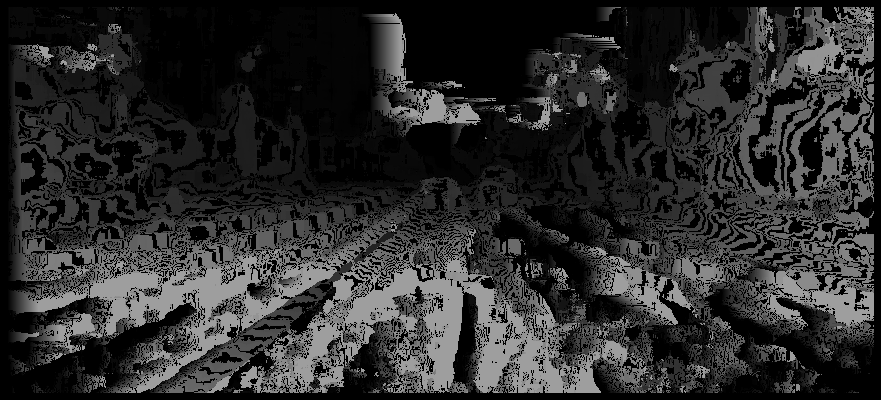

(23.77942265876921,
 (0.34200047646598375,
  0.28350860474877765,
  0.28350860474877765,
  0.1372675810275783,
  0.0770740450827576))

In [68]:
print(fname)
from google.colab.patches import cv2_imshow
d = cv2.GaussianBlur(d, (5,5), 1.5);
cv2_imshow(d)
errors(ground_truth[fname]/256,d/256)

# DP

In [ ]:
def dp_disparity(imageL,imageR,disp_range):
    height = imageL.shape[0]
    width = imageR.shape[1]
    dm = []
    for line in tqdm(range(height)):
        c = np.ones((width,disp_range),dtype=np.int16) * float('inf')
        for i in range(width):
            for j in range(disp_range):
                if i+j > disp_range//2:
                  if i+j-disp_range//2 < width:
                    j_ = max(j-1,0)
                    i_ = max(i-1,0)
                    c[i][j] = min(c[i_][j],c[i_][min(j+1,disp_range-1)],c[i][j_]) + np.abs(imageL[line][i]-imageR[line][i+j-disp_range//2])
                else:
                  c[i][j] = 0

        x = disp_range//2
        y = width-1
        dispres = np.ones((width,disp_range))
        while y > 0:
            da = np.array([c[y-1,x],c[y-1,min(disp_range-1,x + 1)], c[y,max(0,x-1)]])
            inx = np.argmin(da)
            if inx == 0:
                dispres[y][x] = 0
                y -= 1
            elif inx == 1:
                x += 1
                y -= 1
            else:
                x -= 1
        disparity = []
        for i in range(width):
            try:
                col = list(dispres[i]).index(0)
                disparity.append(abs(col-disp_range//2))
            except:
                disparity.append(0)
        dm.append(disparity)
    return  np.array(dm).astype(np.int16)



In [44]:
start = time.time()
d = dp_disparity(imgs[fname][0],imgs[fname][1],32)
print("\n run time: %.2f"%(time.time()-start))

  0%|          | 0/400 [00:00<?, ?it/s]C:\Users\asus\AppData\Local\Temp\ipykernel_7956\3509090264.py:13: RuntimeWarning: overflow encountered in ubyte_scalars
  c[i][j] = min(c[i_][j],c[i_][min(j+1,disp_range-1)],c[i][j_]) + np.abs(imageL[line][i]-imageR[line][i+j-disp_range//2])
100%|██████████| 400/400 [00:50<00:00,  7.91it/s]


 run time: 50.59


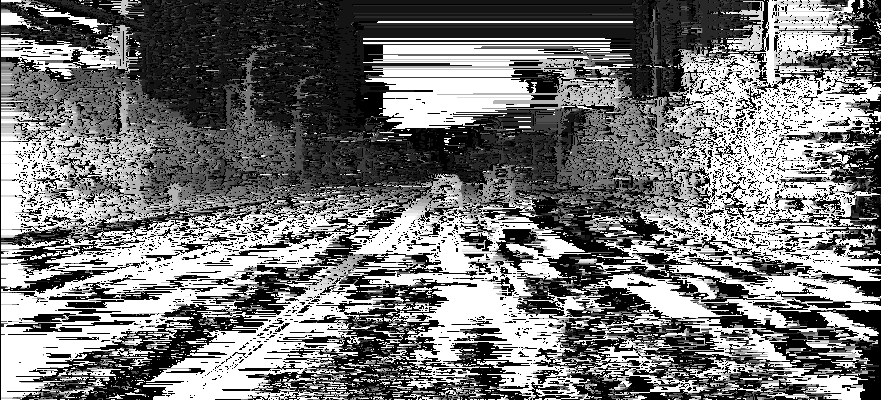

(25.036323010906912,
 (0.2850060692690785,
  0.22137517158447628,
  0.22137517158447628,
  0.08873611725600972,
  0.04821381978241387))

In [114]:
plt.imshow(d * 20, cmap='gray')
plt.axis('off')
plt.show()
errors(ground_truth[fname]/256,d)

# Image Pyramid

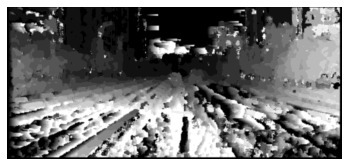

(25.23509338737808, (0.06895143450294387, 0.0033579507424928248, 0.0033579507424928248, 0.00039705498644340833, 0.00012478871002507118))
run time: 14.393214464187622


In [38]:
img_name = "2018-07-09-16-11-56_2018-07-09-16-11-56-702"
start = time.time()
SEARCH_BLOCK_SIZE = 16

rows, cols = map(int, imgs[img_name][0].shape)
pyrl = cv2.pyrDown(imgs[img_name][0], dstsize=(cols // 2, rows // 2))
pyrr = cv2.pyrDown(imgs[img_name][1], dstsize=(cols // 2, rows // 2))


pyrd = ssd(pyrl,pyrr,5)
d = cv2.pyrUp(pyrd)


d = np.r_[d,np.zeros((rows - d.shape[0],d.shape[1]))]
d = np.c_[d,np.zeros((d.shape[0],cols - d.shape[1]))]

plt.imshow(d * 20, cmap='gray')
plt.axis('off')
plt.show()
print(errors(ground_truth[img_name]/256,d))

print("run time:", time.time() - start)

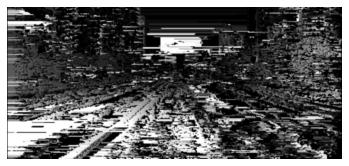

(25.60091585697944, (0.05211630307774336, 0.012422148861586631, 0.012422148861586631, 0.002824762617840248, 0.0012365426720666146))
run time: 14.752570390701294


In [77]:
img_name = "2018-07-09-16-11-56_2018-07-09-16-11-56-702"
start = time.time()
SEARCH_BLOCK_SIZE = 16

rows, cols = map(int, imgs[img_name][0].shape)
pyrl = cv2.pyrDown(imgs[img_name][0], dstsize=(cols // 2, rows // 2))
pyrr = cv2.pyrDown(imgs[img_name][1], dstsize=(cols // 2, rows // 2))


pyrd = dp_disparity(pyrl,pyrr,16)
d = cv2.pyrUp(pyrd)


d = np.r_[d,np.zeros((rows - d.shape[0],d.shape[1]))]
d = np.c_[d,np.zeros((d.shape[0],cols - d.shape[1]))]

plt.imshow(d * 20, cmap='gray')
plt.axis('off')
plt.show()
print(errors(ground_truth[img_name]/256,d))

print("run time:", time.time() - start)

